In [1]:
import sys
if sys.version_info[0] < 3:
    # python 2 backwards compatibility
    import Queue as queue
else:
    import queue
import threading
import os
import logging

from scipy.constants import zero_Celsius
import numpy as np

import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Sequence
from sqlalchemy import Column, Integer, Float, Boolean, String
from sqlalchemy.orm import sessionmaker
from sqlalchemy.orm.scoping import scoped_session

logger = logging.getLogger('raspbrewry')
logger.setLevel(logging.DEBUG)

simulation = threading.Event()

In [2]:
import time as time_module
class Time(object):
    def __init__(self, timelapse = 1.0):
        self.timelapse = timelapse
        self.start_time = time_module.time()
    def time(self):
        return (time_module.time() - self.start_time) * self.timelapse + self.start_time
    def sleep(self, sleeptime):
        return time_module.sleep(sleeptime)

In [3]:
overwrite_db = True
if overwrite_db:
    os.remove('test.db')
engine = create_engine('sqlite:///test.db', echo=False)
Base = declarative_base()
Base.metadata.create_all(engine)
sessionfactory = sessionmaker(bind=engine)
terminate = threading.Event()

In [4]:
class TemperatureSensor1(Base):
    __tablename__ = 'temperature sensor 1'
    id = Column(Integer, Sequence('TemperatureSensor1_id_seq'), primary_key=True)
    time = Column(Float) # seconds since the Epoch
    temperature = Column(Float) # centigrade

    def __repr__(self):
        return "<TemperatureSensor1(time='%f', temperature='%f')>" % (self.time, self.temperature) 

def Read_TemperatureSensor1():
    logger.info('starting Read_TemperatureSensor1')
    session = scoped_session(sessionfactory)
    while not terminate.is_set():
        if simulation.is_set():
            T=model.T
        else:
            T=-999.999 # get temperature in centigrade
        update = TemperatureSensor1(time=time.time(), temperature=T)
        session.add(update)
        session.commit()
        time.sleep(1)
        #now = session.query(TemperatureSensor1).order_by(TemperatureSensor1.id.desc()).first()
        #now
        #now.time
        #now.temperature
        #for instance in session.query(TemperatureSensor1).order_by(TemperatureSensor1.id.desc()):
            #print instance.time, instance.temperature 
    logger.info('terminating Read_TemperatureSensor1')

In [5]:
class Heater1(Base):
    __tablename__ = 'heater 1'
    id = Column(Integer, Sequence('Heater1_id_seq'), primary_key=True)
    time = Column(Float) # seconds since the Epoch
    on_state = Column(Boolean) # True is on, False is off

    def __repr__(self):
        return "<Heater1(time='%f', on_state='%s')>" %(self.time, str(self.on_state)) 

def Read_Heater1():
    logger.info('starting Read_Heater1')
    session = scoped_session(sessionfactory)
    while not terminate.is_set():
        on = True
        off = False
        update = Heater1(time=time.time(), on_state = on)
        session.add(update)
        session.commit()
        time.sleep(1)
        #now = session.query(Heater1).order_by(Heater1.id.desc()).first()
        #now
        #now.time
        #now.temperature
        #for instance in session.query(Heater1).order_by(Heater1.id.desc()):
            #print instance.time, instance.temperature
    logger.info('terminating Read_Heater1')

In [6]:
class Model(object):
    def __init__(self, volume, heatpower, loss, roomtemp, T0):
        self.volume = volume
        self.heatpower = heatpower
        self.loss = loss
        self.roomtemp = roomtemp
        self.T = T0
        self.H0 = 0
        self.reaction = 0.05
        self.pid_value = 0
        self.Cs = 4.1813e3 # J/(kg*K)
    def step(self, delta):
        E0 = self.volume*self.Cs*self.T
        self.H0 = self.H0 + self.reaction*(self.heatpower * self.pid_value - self.H0) * delta
        E1 = E0 + self.H0 * delta + self.loss * (self.roomtemp - self.T) * delta
        self.T = E1 / (self.Cs * self.volume)
    def simulate(self):
        logger.info('starting simulation')
        simulation.set()
        while not terminate.is_set():
            self.step(1)
            time.sleep(1)
        logger.info('terminating simulation')

volume = 35 # kg
heatpower = 1600 # Watt
loss = 10 # W/K
roomtemp = 25 # C
T0 = 15 # C
model = Model(volume, heatpower, loss, roomtemp, T0)

    

In [7]:
Base.metadata.create_all(engine)

# time = Time() # realtime mode
time = Time(timelapse = 10.0) # testing timelapse mode
q = queue.Queue()

t = threading.Thread(target=model.simulate)
t.daemon = True
t.start()

t = threading.Thread(target=Read_TemperatureSensor1)
t.daemon = True
t.start()

t = threading.Thread(target=Read_Heater1)
t.daemon = True
t.start()
time.sleep(.1) # give threads time to populate database

INFO:raspbrewry:starting simulation
INFO:raspbrewry:starting Read_TemperatureSensor1
INFO:raspbrewry:starting Read_Heater1


In [8]:
session = sessionfactory()
def get_last(session, table, timeout=2.):
    value = session.query(table).order_by(table.id.desc()).first()
    if time.time() > value.time + timeout:
        logger.warning('last value older than %3.2fs: %s' % (timeout, table))
    return value

In [9]:

print(get_last(session, TemperatureSensor1))
print(get_last(session, Heater1))

<TemperatureSensor1(time='1444673776.292019', temperature='15.003416')>
<Heater1(time='1444673776.286450', on_state='True')>


In [55]:
terminate.set() # shut theads down

INFO:raspbrewry:terminating Read_TemperatureSensor1
INFO:raspbrewry:terminating Read_Heater1


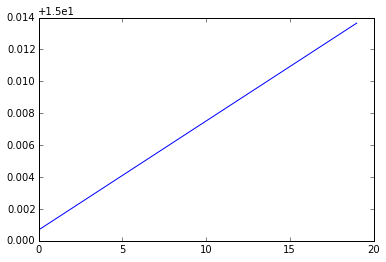

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
query = session.query(TemperatureSensor1.temperature).order_by(TemperatureSensor1.id)
plt.plot([r for r, in query.all()])